# ResNet50 on MURA

Directly using ResNet50 from Keras: https://keras.io/applications/#resnet50

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.resnet50 import ResNet50
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
%load_ext autotime

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 595 ms


## Loading Data

Loading MURA images

In [3]:
import utils # importing from our utils functions

time: 3.44 s


In [4]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 2.19 s


We can look at the shape of the dataset:

In [5]:
x_train.shape

(36808, 256, 256)

time: 3.96 ms


In [6]:
size = x_train.shape[1]

time: 3.21 ms


Visually inspect an image:

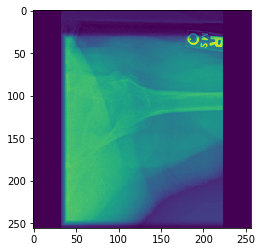

time: 122 ms


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

## Data preparation

reshape the data to `size*size*1`  (1 for channel)

In [8]:
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 1.19 ms


In [9]:
x_train.shape

(36808, 256, 256, 1)

time: 2.06 ms


Convert our data type to float32 and normalize our data values to the range [0, 1].

In [10]:
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

time: 4.07 s


even though we have a 0-1 target, it's easier if we frame it in terms of a 2-class classification task.

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

time: 1.64 ms


In [12]:
y_train.shape

(36808, 2)

time: 5.9 ms


## Define model architecture

In [24]:
# declare sequential model
model = ResNet50(input_shape=(256, 256, 1), weights=None, classes=2)

time: 4.93 s


In [14]:
model.output_shape

(None, 2)

time: 2.09 ms


## Compile model

We still need to define the loss and optimization method. Keras has a variety of [loss functions](https://keras.io/losses/) and out-of-the-box [optimizers](https://keras.io/optimizers/) to choose from. For this tutorial we'll use cross-entropy as loss function and [Adam](https://arxiv.org/abs/1412.6980) as our optimizer.

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

time: 32.6 ms


## Fitting the model

In [16]:
model.fit(x_train, y_train, 
          batch_size=16, epochs=50, verbose=2)

Epoch 1/50
 - 557s - loss: 0.7176 - acc: 0.5789
Epoch 2/50
 - 599s - loss: 0.6711 - acc: 0.5937
Epoch 3/50
 - 594s - loss: 0.6687 - acc: 0.5958
Epoch 4/50
 - 600s - loss: 0.6699 - acc: 0.5937
Epoch 5/50
 - 591s - loss: 0.6704 - acc: 0.5961
Epoch 6/50
 - 604s - loss: 0.6669 - acc: 0.5983
Epoch 7/50
 - 601s - loss: 0.6628 - acc: 0.6007
Epoch 8/50
 - 565s - loss: 0.6568 - acc: 0.6014
Epoch 9/50
 - 579s - loss: 0.6483 - acc: 0.6202
Epoch 10/50
 - 564s - loss: 0.6416 - acc: 0.6254
Epoch 11/50
 - 561s - loss: 0.6295 - acc: 0.6429
Epoch 12/50
 - 591s - loss: 0.6146 - acc: 0.6608
Epoch 13/50
 - 566s - loss: 0.5968 - acc: 0.6775
Epoch 14/50
 - 572s - loss: 0.5843 - acc: 0.6880
Epoch 15/50
 - 592s - loss: 0.5712 - acc: 0.7000
Epoch 16/50
 - 594s - loss: 0.5590 - acc: 0.7137
Epoch 17/50
 - 588s - loss: 0.5484 - acc: 0.7222
Epoch 18/50
 - 574s - loss: 0.5416 - acc: 0.7263
Epoch 19/50
 - 572s - loss: 0.5310 - acc: 0.7391
Epoch 20/50
 - 581s - loss: 0.5229 - acc: 0.7414
Epoch 21/50
 - 595s - loss: 0

time: 8h 10min 4s


In [20]:
model.save('./trained_models/1_1_resnet50_mura3.h5')

time: 22.9 s


We can check how loss and accuracy change over epochs

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [13]:
with tf.device('/GPU:0'):
    model = load_model('./trained_models/1_1_resnet50_mura3.h5')

time: 17.6 s


## Evaluating our model on the test set

### Loss and Accuracy

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 14.7 s


In [15]:
score

[1.950570273854265, 0.6997184859501931]

time: 2.15 ms


In [16]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 14.6 s


In [17]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1] + 0.8
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 2.94 ms


### Cohen's Kappa

In [18]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 4.67 ms


In [19]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 977 µs


In [20]:
kappa

0.3963216596591052

time: 2.68 ms


[[1249  418]
 [ 542  988]]


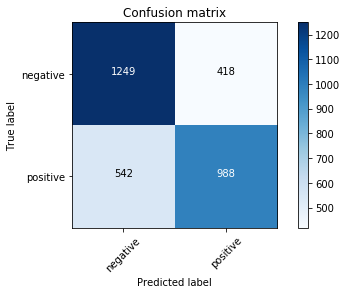

time: 186 ms


In [21]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))

In [ ]:
model.summary()